In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
#import gitfame

In [5]:
# print the gitfame data for the repo
#gitfame.main(['--sort=commits', '-wt'])

Part 1: Implementing and plotting the Mandelbrot set

In [6]:
# hyperparameters
# bounds for the search space [x,y]
lowerBounds = [-2.0, -1.5]
upperBounds = [1.0, 1.5]

In [7]:
def mandelbrot(c, max_iter):
    '''
    Determines whether complex number c lies within the mandelbrot set via the escape time algorithm.
    
    Args:
        c (complex):    Complex number to be tested.
        max_iter (int): Number of iterations to perform.
        
    Returns:
        z (complex): The complex number at iteration max_iter.
        n (int): The number of iterations before the escape condition is reached.
    '''
    z = 0 + 0j
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
        
    return z, n

def plot_mandelbrot(width, height, max_iter):
    '''
    Plots the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        None
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set = np.empty((height, width))
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, mandelbrot_set[i, j] = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set, extent=(lowerBounds[0], upperBounds[0], lowerBounds[1], upperBounds[1]),
               cmap='inferno', interpolation='bilinear')
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()
    
    print(mandelbrot_set_bool)
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set_bool)
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()

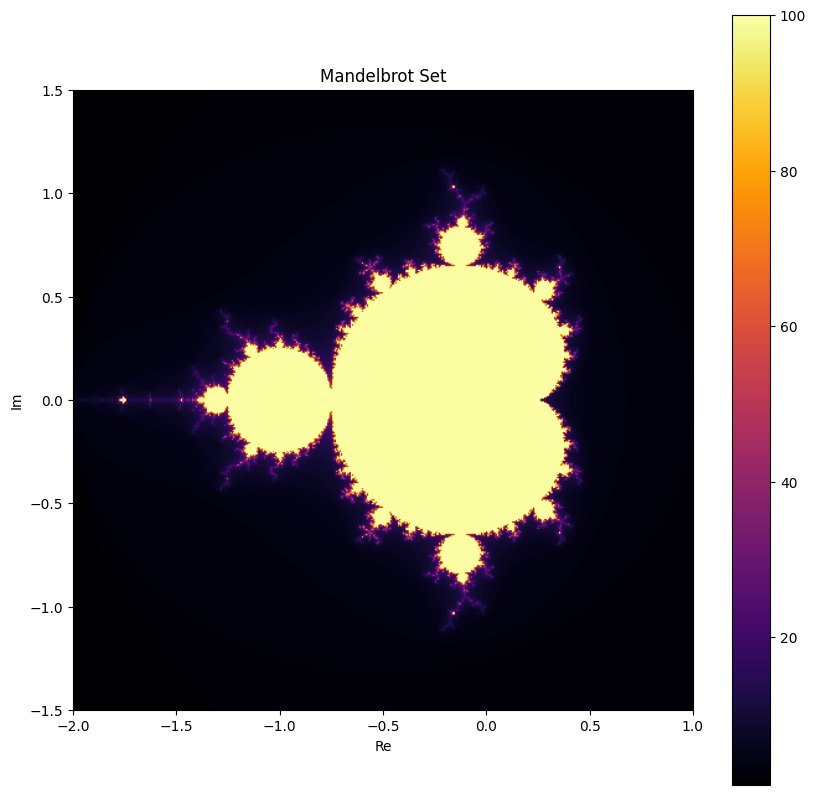

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


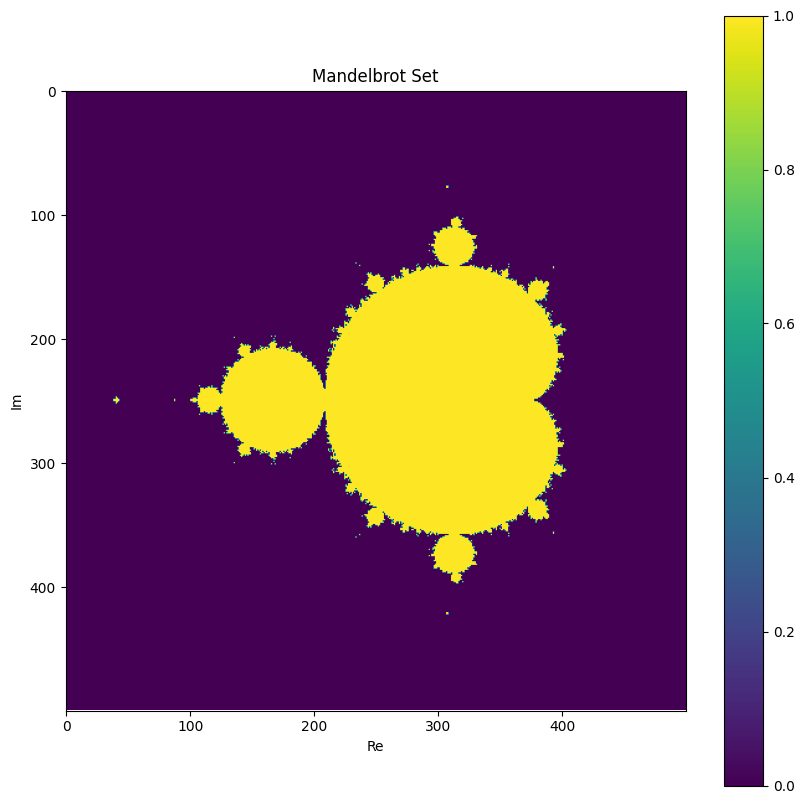

In [8]:
# Plot the Mandelbrot set with given parameters
plot_mandelbrot(500, 500, 100)

Part 2

In [9]:
def get_random_sample(sample_size,sampling_method="random",seed=42):
    '''	
    Generate a random sample of points in the square defined by lowerBounds and upperBounds.

    Args:
        sample_size (int): Number of points to sample.
        sampling_method (str): Method to use for sampling. Options are "random", "latin", "orthogonal".

    Returns:
        sample_scaled (numpy.ndarray): Array of shape (sample_size, 2) containing the sampled points.
    '''
    np.random.seed(seed)
    # use latin hypercube sampling to sample points in the square
    if sampling_method == "latin":
        sampler = qmc.LatinHypercube(d=2,strength=1)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)

    # number of points needs to be p**2 where p is a prime number
    if sampling_method == "orthogonal":
        sampler = qmc.LatinHypercube(d=2,strength=2)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)
    
    # use pure random sampling
    if sampling_method == "random":
        sample_scaled = np.random.uniform(low=lowerBounds, high=upperBounds, size=(sample_size, 2))
    
    return sample_scaled

KeyboardInterrupt: 

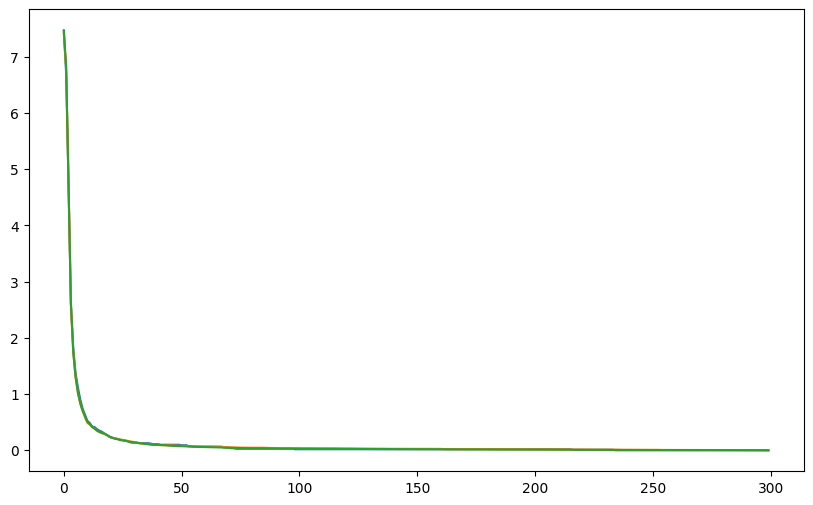

In [10]:
def compute_and_plot_i_errors(sample_sizes,max_iter,sampling_method):
    """Investigate errors on MC area due to finiteness of i (iterations)

    Args: 
    sample_sizes (list): list of sample sizes (int) [1000,...,50000]
    max_iter (int): max number of iterations
    sampling_method (str): choose sampling method (random, latin, orthogonal)

    Output:
    Plot of errors due to i, iterations vs (Area_i,s - Area_j,s for j in (0,..,i)) 

    """

    area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
    fig, ax = plt.subplots(1,1,figsize=(10,6))

    # Do for multiple runs to get a confidence interval? Or not?
    
    # check MC for one value of max_iter, do for multiple sample sizes
    for sample_size in sample_sizes:

        # get a random sample
        sample_scaled = get_random_sample(sample_size,sampling_method)
        areas = []

        # find area at each iteration 
        for iter in range(max_iter):
            mc_count = 0
                
            for i in range(sample_size):
                    z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
                    
                    if abs(z) <= 2:
                        mc_count += 1
                        
            current_area = (float(mc_count) * area_of_region) / sample_size
            areas.append(current_area)
            
        areas = np.array(areas)

        # Area_i,s - Area_j,s for j in (0,..,i)
        Ais_Ajs = np.abs(areas - areas[-1]) 
        
        ax.plot(np.arange(0,len(Ais_Ajs),1), Ais_Ajs,label=f"sample size={sample_size}")


    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.set_ylabel(r"|$A_{i,s}$ - $A_{j,s}$|"+ f" j={max_iter}")
    ax.set_xlabel("iterations")
    ax.set_title(f"Errors on MC due to finiteness of i, (sampling method: {sampling_method})")
    
    plt.show()


max_iter = 300
sample_sizes = [1000,5000,10000,50000]

compute_and_plot_i_errors(sample_sizes,max_iter,sampling_method="random")

Converged: Area estimate = 1.5732, Samples = 10000, Iterations = 100


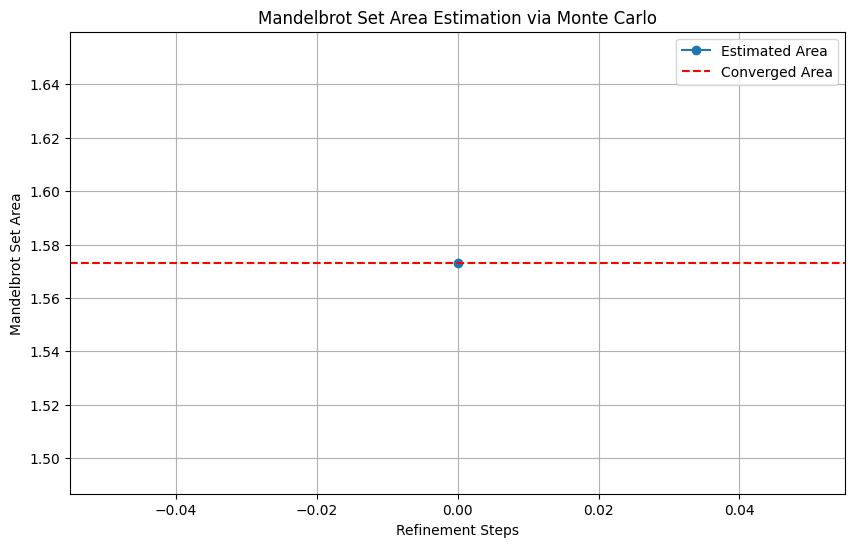

Estimated Mandelbrot set area: 1.5732 with s=10000 and i=100


In [11]:
def monte_carlo_mandelbrot_comparable(area_of_region, initial_samples, initial_iters, threshold, sampling_method, max_steps=20):
    """
    Monte Carlo estimation of Mandelbrot set area ensuring comparable errors for i and s.
    
    Args:
    area_of_region: Area of the sampled region in the complex plane.
    initial_samples: Starting sample size (s).
    initial_iters: Starting number of iterations (i).
    threshold: Convergence threshold for area change.
    max_steps: Maximum refinement steps.

    Returns:
    prev_area = area
    """
    s = initial_samples
    i = initial_iters
    prev_area = 0
    steps = 0
    
    steps_list = []
    area_estimates = []
    
    while steps < max_steps:
        sample_scaled = get_random_sample(s,sampling_method)
        
        # Monte Carlo
        mc_count = 0
        for point in sample_scaled:
            z, _ = mandelbrot(point[0] + 1j * point[1], i)
            if abs(z) <= 2:
                mc_count += 1
        
        current_area = (float(mc_count) * area_of_region) / s

        steps_list.append(steps)
        area_estimates.append(current_area)
        
        # Relative change due to i
        new_i = i * 10
        mc_count_i = 0
        for point in sample_scaled:
            z, _ = mandelbrot(point[0] + 1j * point[1], new_i)
            if abs(z) <= 2:
                mc_count_i += 1
        area_with_new_i = (float(mc_count_i) * area_of_region) / s
        delta_i = abs(area_with_new_i - current_area) / (current_area if current_area != 0 else 1)
        
        # Relative change due to s
        new_s = s * 10
        sample_scaled_new_s = get_random_sample(new_s,sampling_method)
        mc_count_s = 0
        for point in sample_scaled_new_s:
            z, _ = mandelbrot(point[0] + 1j * point[1], i)
            if abs(z) <= 2:
                mc_count_s += 1

        area_with_new_s = (float(mc_count_s) * area_of_region) / new_s
        delta_s = abs(area_with_new_s - current_area) / (current_area if current_area != 0 else 1)
        
        # Check if the changes are comparable
        if delta_i < threshold and delta_s < threshold and abs(delta_i - delta_s) / max(delta_i, delta_s) < 0.5:
            print(f"Converged: Area estimate = {current_area}, Samples = {s}, Iterations = {i}")
            break
        
        print(s,i)
        print(delta_s,delta_i)

        # Update values: alternate between increasing sample size and iterations
        if delta_i > delta_s:
            i = new_i
        else:
            s = new_s
        
        prev_area = current_area
        steps += 1
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(steps_list, area_estimates, marker='o', label='Estimated Area')
    plt.axhline(y=current_area, color='r', linestyle='--', label='Converged Area')
    plt.xlabel('Refinement Steps')
    plt.ylabel('Mandelbrot Set Area')
    plt.title('Mandelbrot Set Area Estimation via Monte Carlo')
    plt.legend()
    plt.grid()
    plt.show()
    
    return current_area, s, i

area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
initial_samples = 10000
initial_iters = 100
threshold = 0.1

estimated_area,s,i = monte_carlo_mandelbrot_comparable(area_of_region, initial_samples, initial_iters, threshold,sampling_method="random")
print(f"Estimated Mandelbrot set area: {estimated_area} with s={s} and i={i}")

Text(0, 0.5, '$A_i - A_{i-1}$')

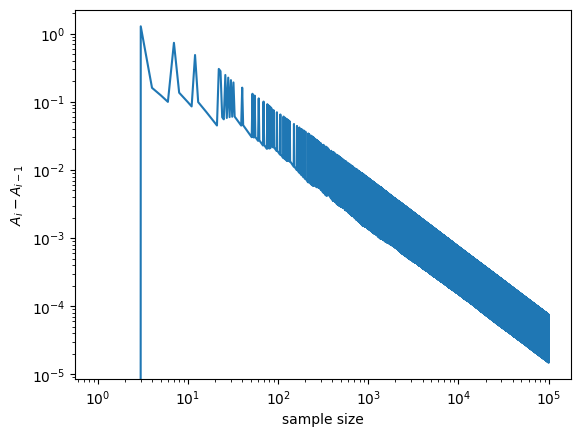

In [12]:
# Choose a threshold for convergence and compare how the value for Area changes compared to previous Area
# Do we test convergence as a function of sample size? 
# s=100000 and i=1000

def find_convergence_samples(iter,sample_size,sampling_method):
    area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1])
    sample_scaled = get_random_sample(sample_size,sampling_method)
    areas = []
    mc_count = 0
    
    for i in range(1,sample_size):
        z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
                    
        if abs(z) <= 2:
            mc_count += 1
                        
        current_area = (float(mc_count) * area_of_region) / i
        areas.append(current_area)

    areas = np.array(areas)
    
    convergence = abs(np.diff(areas))[2::]

    return convergence

sampling_method="random"
sampling_method="orthogonal"
sampling_method="latin"
convergence = find_convergence_samples(1000,100000,sampling_method)

plt.yscale("log")
plt.xscale("log")
plt.plot(convergence)
plt.xlabel("sample size")
plt.ylabel(r"$A_i - A_{i-1}$")

# If we choose convergence at A_i - A(i-1) = 10**(-4)
# We now need to test the convergence rate for the different sample techniques.

KeyboardInterrupt: 

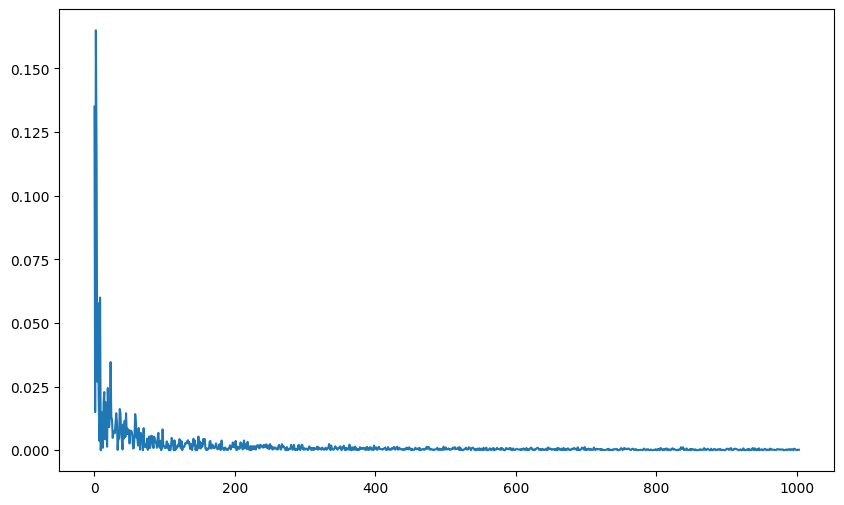

In [13]:
# Function to find convergence
def find_convergence_samples(iter, sample_size, sampling_method, threshold=1e-4, batch_size=100):
    area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1])
    sample_scaled = get_random_sample(sample_size, sampling_method)
    
    areas = []
    mc_count = 0
    convergence_point = None  
    
    for i in range(0, sample_size, batch_size):
        # Process samples in batches 
        batch_samples = sample_scaled[i:i + batch_size]
        for point in batch_samples:
            z, _ = mandelbrot(point[0] + 1j * point[1], iter)
            if abs(z) <= 2:
                mc_count += 1
        
        current_area = (float(mc_count) * area_of_region) / (i + batch_size)
        areas.append(current_area)
        
        # Check for convergence after at least two values
        if len(areas) > 1:
            delta = abs(areas[-1] - areas[-2])
            if delta < threshold and convergence_point is None:
                convergence_point = i + batch_size  # Sample size at convergence
    
    # Compute convergence
    areas = np.array(areas)
    convergence = abs(np.diff(areas))
    
    return convergence, convergence_point



iter = 1000
# sample_size = 100000
# sample size as (closest prime number to sqrt(100000)) ** 2, for orthogonal sampling
sample_size = 317 ** 2
sampling_methods = ["random", "orthogonal", "latin"]
threshold = 1e-4

plt.figure(figsize=(10, 6))
convergence_points = {}
for sampling_method in sampling_methods:
    convergence, convergence_point = find_convergence_samples(iter, sample_size, sampling_method, threshold)
    plt.plot(convergence, label=f"{sampling_method} (conv. @ {convergence_point})")
    convergence_points[sampling_method] = convergence_point

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Sample Size")
plt.ylabel(r"$A_i - A_{i-1}$")
plt.title(f"Convergence Comparison of Sampling Methods (Threshold = {threshold})")
plt.legend()
plt.grid()
plt.show()

for method, point in convergence_points.items():
    print(f"Sampling Method: {method}, Convergence at Sample Size: {point}")
plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
plt.xlabel("iterations")
plt.show()

Importance sampling

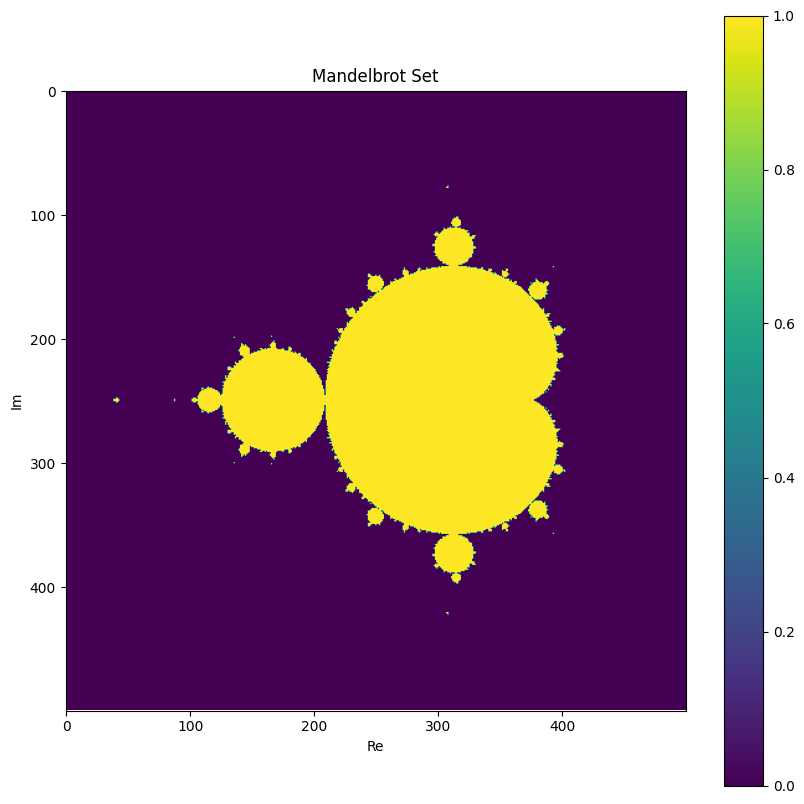

In [163]:
# create a precomputed map of the Mandelbrot set to identify boundary regions.
def precompute_mandelbrot(width, height, max_iter):
    '''
    Precomputes the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        mandelbrot_set_bool (numpy.ndarray): Array of shape (height, width) containing the Mandelbrot set.
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, _ = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    return mandelbrot_set_bool

# plot the precomputed Mandelbrot set
mandelbrot_set_bool = precompute_mandelbrot(500, 500, max_iter)
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_set_bool)
plt.colorbar()
plt.title("Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

[(77, 307), (78, 306), (78, 307), (102, 314), (102, 315), (103, 312), (103, 313), (103, 315), (104, 311), (104, 316), (105, 311), (105, 317), (106, 310), (106, 317), (107, 310), (107, 317), (108, 311), (108, 317), (109, 311), (109, 312), (109, 315), (109, 316), (110, 309), (110, 313), (110, 314), (111, 304), (111, 307), (111, 308), (111, 310), (111, 311), (111, 312), (111, 315), (111, 316), (111, 317), (112, 304), (112, 305), (112, 306), (112, 318), (112, 319), (112, 320), (113, 303), (113, 321), (113, 322), (113, 323), (114, 298), (114, 302), (114, 322), (115, 297), (115, 299), (115, 301), (115, 323), (115, 324), (116, 296), (116, 300), (116, 324), (117, 297), (117, 298), (117, 324), (117, 327), (117, 328), (117, 329), (118, 299), (118, 325), (118, 326), (118, 328), (119, 298), (119, 327), (119, 328), (120, 298), (120, 326), (121, 297), (121, 326), (122, 297), (122, 327), (123, 297), (123, 327), (124, 295), (124, 296), (124, 327), (125, 295), (125, 296), (125, 327), (126, 297), (126, 

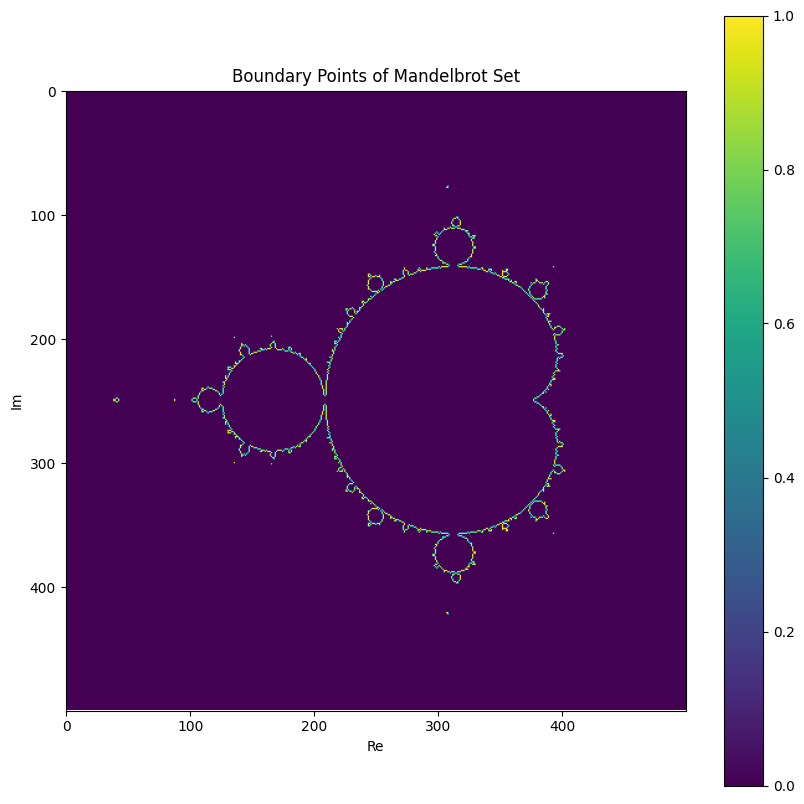

In [164]:
# use the precomputed map to identify boundary regions
def get_boundary_points(mandelbrot_set_bool):
    '''
    Identifies boundary points in the Mandelbrot set.
    
    Args:
        mandelbrot_set_bool: Array containing the Mandelbrot set.
    
    Returns:
        boundary_points (list): List of tuples containing the coordinates of boundary points.
    '''
    
    boundary_points = []
    
    # iterate over the Mandelbrot set to find boundary points
    for i in range(1, mandelbrot_set_bool.shape[0] - 1):
        # check if the point is in the Mandelbrot set and has a neighbour that is not
        for j in range(1, mandelbrot_set_bool.shape[1] - 1):
            if mandelbrot_set_bool[i, j] == 1:
                if (mandelbrot_set_bool[i - 1, j] == 0 or mandelbrot_set_bool[i + 1, j] == 0 
                    or mandelbrot_set_bool[i, j - 1] == 0 or mandelbrot_set_bool[i, j + 1] == 0):
                    boundary_points.append((i, j))
    
    return boundary_points

# get the boundary points of the Mandelbrot set
boundary_points = get_boundary_points(mandelbrot_set_bool)
print(boundary_points)

# plot the boundary points
all_points = np.zeros(mandelbrot_set_bool.shape)
for point in boundary_points:
    all_points[point[0], point[1]] = 1

plt.figure(figsize=(10, 10))
plt.imshow(all_points)
plt.colorbar()
plt.title("Boundary Points of Mandelbrot Set")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

In [190]:
# use list of boundary points to assign a weight to each point in the sample
def get_weights(sample_scaled, boundary_points, bound_emphasis=1):
    '''
    Assigns a weight to each point in the sample based on its proximity to the closest boundary point.

    The distance function:
        d(x, y) = min ( sqrt((x - x_bp)^2 + (y - y_bp)^2) ) for all boundary points (x_bp, y_bp)

        Where (x, y) are the coordinates of a point in the sample and (x_bp, y_bp) are the coordinates of a boundary point.


    The weight function:
        w(x, y) = bound_emphasis * d(x, y)

        The bound_emphasis parameter can be used to adjust the influence of the boundary points on the weights.

    Normalization:
        The weights are normalized such that the sum of all weights sums to 1.

    Args:
        sample_scaled (numpy.ndarray): Array of shape (sample_size, 2) containing the sampled points.
        boundary_points (list): List of tuples containing the coordinates of boundary points.
    
    Returns:
        weights (numpy.ndarray): Array of shape (sample_size,) containing the weights of each point in the sample.
    '''
    epsilon = 1e-6
    
    # initialize the weights array
    raw_weights = np.zeros(sample_scaled.shape[0])

    # iterate over the sample to calculate the weights
    for i in range(sample_scaled.shape[0]):
        x, y = sample_scaled[i]
        min_distance = np.inf
        
        # find the closest boundary point
        for point in boundary_points:
            x_bp, y_bp = point
            distance = np.sqrt((x - x_bp)**2 + (y - y_bp)**2)
            if distance < min_distance:
                min_distance = distance
        
        # assign the weight to the sample point
        raw_weights[i] = bound_emphasis / (min_distance + epsilon)
        print(raw_weights[i])

    # normalize the weights
    weights = raw_weights / np.sum(raw_weights)
    
    return weights

In [166]:
def sample_on_weight(sample, weights, sample_size, seed=42):
    '''
    Samples points from the given sample based on the weights assigned to each point.

    Args:
        sample: Array containing the sampled points.
        weights: Array containing the weights of each point in the sample.
        sample_size: Number of points to sample.
    
    Returns:
        sample_weighted: Array containing the sampled points based on the weights.
    '''
    np.random.seed(seed)

    assert len(sample) == len(weights), "Sample and weights must have the same length."
    assert np.isclose(np.sum(weights), 1), "Weights must sum to 1."
    assert sample_size <= len(sample), "Sample size must be less than or equal to the sample length."
    
    # sample points based on the weights
    sample_weighted = sample[np.random.choice(sample.shape[0], size=sample_size, p=weights)]
    
    return sample_weighted

In [167]:
def mandelbrot_check(sample, weights, max_iter):
    # Mandelbrot membership check and weighted sum
    weighted_sum = 0.0
    for i, point in enumerate(sample):
        c = point[0] + 1j * point[1]
        _, is_in_set = mandelbrot(c, max_iter)
        if is_in_set:
            weighted_sum += weights[i]  # Accumulate weighted contribution
        else:
            print(f"Point {point} is not in the Mandelbrot set.")

    return weighted_sum

In [ ]:
def mandelbrot_check_weighted(sample, weights, max_iter, escape_threshold):
    """
    Checks if points are in the Mandelbrot set and computes a weighted sum for points inside the set.

    Args:
        sample (numpy.ndarray): Array of points to check, each of shape [num_samples, 2] (real, imaginary).
        weights (numpy.ndarray): Array of weights corresponding to each point.
        max_iter (int): Maximum number of iterations to check if the point belongs to the Mandelbrot set.
        escape_threshold (float): The escape threshold for the Mandelbrot set (usually 2).

    Returns:
        weighted_sum (float): The weighted sum of points that are inside the Mandelbrot set.
    """
    weighted_sum = 0.0

    # Loop through each sample point
    for i, point in enumerate(sample):
        c = point[0] + 1j * point[1]  # Convert to complex number

        # Check if the point is in the Mandelbrot set
        z = 0  # Initialize z
        is_in_set = True
        for _ in range(max_iter):
            z = z * z + c  # Mandelbrot iteration
            if abs(z) > escape_threshold:
                is_in_set = False
                break
        
        # If the point is in the Mandelbrot set, accumulate its weighted contribution
        if is_in_set:
            weighted_sum += weights[i]
    
    return weighted_sum

In [169]:
def find_area_importance(sample, weights, max_iter, lower_bounds, upper_bounds, escape_threshold):
    '''
    Finds the area of the Mandelbrot set using Monte Carlo integration with importance sampling.

    Args:
        sample: Array containing the sampled points (shape: [num_samples, 2]).
        weights: Array of weights (1 / PDF values) for the sampled points.
        mandelbrot_func: Function to check Mandelbrot membership for a point.
                         Should take a complex number and max_iter as input.
        max_iter: Maximum number of iterations for Mandelbrot membership check.
        lower_bounds: Tuple (x_min, y_min) for the sampling region.
        upper_bounds: Tuple (x_max, y_max) for the sampling region.

    Returns:
        current_area (float): The area of the Mandelbrot set estimated using Monte Carlo integration.
    '''
    # Compute the area of the sampling region
    area_of_region = abs(upper_bounds[0] - lower_bounds[0]) * abs(upper_bounds[1] - lower_bounds[1])

    weighted_sum = mandelbrot_check_weighted(sample, weights, max_iter, escape_threshold)

    # Estimate the area
    current_area = (weighted_sum / len(sample)) * area_of_region

    return current_area

0.004165149608092251
0.004143795762687759
0.004154035550944993
0.00414664495382747
0.004156950207664098
0.0041617094429636705
0.00415742393751156
0.004176100900264264
0.004141231039789202
0.004162325203867782
0.004148958545125214
0.004161963881007015
0.0041430358123764836
0.004137611723256795
0.004140980610506605
0.004164394269952382
0.004161096165452033
0.004131341724161473
0.004127662438679002
0.004159101826578414
0.004143936448392396
0.004149425144016655
0.004137195304500113
0.004150330421106683
0.004132624459412813
0.004138242786965722
0.0041621053828218455
0.004177779256864478
0.0041540961510074265
0.004135571899542611
0.00418108857876761
0.0041702321543667185
0.00415929779850217
0.004154092917096397
0.004161757335576692
0.004144583434000032
0.00415158385929254
0.00413419486661202
0.004140324637166278
0.00415144146794259
0.004142680450419599
0.0041701745062574175
0.004156874350781334
0.004161053765107865
0.00415377775581234
0.004142673204909314
0.004153814901595667
0.0041281702668

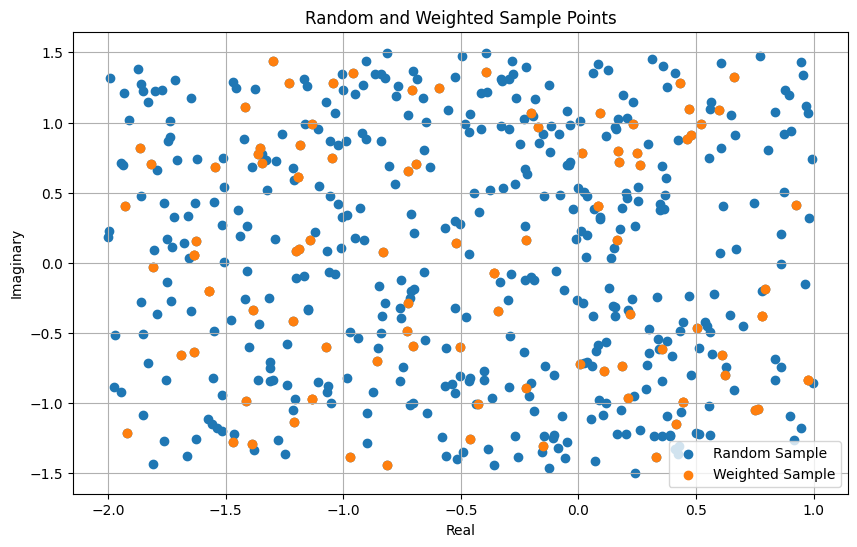

Area of Mandelbrot set for weighted sample: 0.0025201628057113837


In [189]:
# generate random sample
seed = 439
n_initial = 500
n_weighted = 100
max_iter = 10000
upperBounds = (1.0, 1.5)
lowerBounds = (-2.0, -1.5)
bound_emphasis = 1
escape_threshold = 2
sample = get_random_sample(n_initial, sampling_method="random", seed=seed)
sample_weights = get_weights(sample, boundary_points, bound_emphasis)
print(sample_weights)
weighted_sample = sample_on_weight(sample, sample_weights, n_weighted)

# plot distribution of sample points
plt.figure(figsize=(10, 6))
plt.scatter(sample[:, 0], sample[:, 1], label='Random Sample')
plt.scatter(weighted_sample[:, 0], weighted_sample[:, 1], label='Weighted Sample')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Random and Weighted Sample Points')
plt.legend()
plt.grid()
plt.show()

# calculate the area of the Mandelbrot set for the random sample and the weighted sample
area_weighted = find_area_importance(weighted_sample, sample_weights, max_iter, lowerBounds, upperBounds, escape_threshold)
print(f"Area of Mandelbrot set for weighted sample: {area_weighted}")